In [ ]:
from math import ceil, floor
from tqdm import tqdm
import random
import pickle
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans

from google.colab import output as colab_output
colab_output.enable_custom_widget_manager()
import gdown

In [ ]:
!gdown --id 1-JdHF_fHRJtS9Yr-KOiSqSZIK0kotoz_
!gdown --id 1-H5xzRDJo92H5sFUJ2WK_1b4E4u5iIIi

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-JdHF_fHRJtS9Yr-KOiSqSZIK0kotoz_
To: /content/movies_ml_1m.pickle
100% 591k/591k [00:00<00:00, 48.6MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-H5xzRDJo92H5sFUJ2WK_1b4E4u5iIIi
To: /content/ratings_ml_1m.pickle
100% 24.0M/24.0M [00:00<00:00, 48.3MB/s]


In [ ]:
class NeuralMatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        self.fc = torch.nn.Linear(n_factors, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def get_user_embedding(self, user_id):
        return self.user_factors(user_id)
    
    def get_movie_embedding(self, item_id):
        return self.item_factors(item_id)

    def forward(self, users, items, last_layer = False):
        users = self.user_factors(users)
        items = self.item_factors(items)
        mul = torch.mul(users, items)
        if last_layer:
            return torch.mul(torch.sign(self.fc.weight), mul)
        return torch.squeeze(self.sigmoid(self.fc(mul)))

class NeuralColabrativeFiltering(torch.nn.Module):
    def __init__(self, n_user, n_items, n_factors, num_features, num_layers, last_layer, catogories_from_movieId):
        super().__init__()
        self.catogories_from_movieId = catogories_from_movieId

        self.user_factors = torch.nn.Embedding(n_user, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors-num_features, sparse=True)
        self.catogories = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_features),
            torch.nn.ReLU()
        )

        self.last_layer = last_layer
        self.fc_layers = torch.nn.ModuleList()
        layer_size = 2*n_factors
        ratio = (last_layer/layer_size)**(1/(num_layers-1))
        for i in range(num_layers-1):
          out_layer = ceil(ratio*layer_size) if i != num_layers - 2 else last_layer
          self.fc_layers.append(torch.nn.Linear(layer_size, out_layer))
          self.fc_layers.append(torch.nn.ReLU())
          layer_size = out_layer

        self.fc = torch.nn.Linear(last_layer, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def get_user_embedding(self, user_id):
        return self.user_factors(user_id)
    
    def get_movie_embedding(self, item_id):
        return torch.cat([self.item_factors(item_id), self.catogories(self.catogories_from_movieId[item_id])], dim=-1)

    def forward(self, userIds, itemIds, last_layer = False):
        users = self.user_factors(userIds)
        items = self.item_factors(itemIds)
        features = self.catogories(self.catogories_from_movieId[itemIds])

        x = torch.cat([users,items,features],dim=-1)

        for layer in self.fc_layers:
            x = layer(x)
        if last_layer:
          return torch.mul(torch.sign(self.fc.weight), x)
        return torch.squeeze(self.sigmoid(self.fc(x)))

class NeuMF(torch.nn.Module):
    def __init__(self, model_mf, model_ncf, last_layer):
        super().__init__()
        self.model_mf = model_mf
        self.model_ncf = model_ncf

        self.fc_last_layer = torch.nn.Sequential(
            torch.nn.Linear(self.model_ncf.last_layer + self.model_mf.n_factors, last_layer),
            torch.nn.ReLU()
        )
        self.last = torch.nn.Linear(last_layer, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def get_user_embedding(self, user_id):
        return torch.cat([self.model_mf.user_factors(user_id), self.model_ncf.user_factors(user_id)],dim=-1)
    
    def get_movie_embedding(self, item_id):
        return torch.cat([self.model_mf.get_movie_embedding(item_id), self.model_ncf.get_movie_embedding(item_id)],dim=-1)
        
    def forward(self, userIds, itemIds, last_layer=False):
        x = self.fc_last_layer(torch.cat([self.model_mf(userIds, itemIds,True), self.model_ncf(userIds, itemIds,True)], dim=-1)) 
        if last_layer:
            return torch.mul(torch.sign(self.last.weight), x)
        return torch.squeeze(self.sigmoid(self.last(x)))

In [ ]:
NUM_USERS = 6040 
NUM_MOVIES = 3883

In [ ]:
ratings = None
with open('ratings_ml_1m.pickle', 'rb') as handle:
    ratings = pickle.load(handle)
ratings = ratings[ratings["userId"] < NUM_USERS]
ratings = ratings[ratings["movieId"] < NUM_MOVIES]

movies = None
with open('movies_ml_1m.pickle', 'rb') as handle:
    movies = pickle.load(handle)
movies = movies[:NUM_MOVIES]

movies_tensor = torch.from_numpy(movies.values).to(torch.float32).cuda()

In [ ]:
def make_dataset(ratings):
  u_tensor = torch.from_numpy(ratings['userId'].values.astype('long')).to(torch.long).cuda()
  m_tensor = torch.from_numpy(ratings['movieId'].values.astype('long')).to(torch.long).cuda()
  y_tensor = torch.from_numpy(ratings['rating'].values.astype('long')).to(torch.float32).cuda()
  dataset = TensorDataset(u_tensor, m_tensor, y_tensor)
  return dataset

In [ ]:
class make_top_k():
  def __init__(self, model):
    self.model = model
  
  def train(self, dataset, lr, epoch, loss_func, batch_size, extra):
    if extra is not None:
      self.train_(self.model.model_mf, dataset, *extra[0])
      self.train_(self.model.model_ncf, dataset, *extra[1])
    self.train_(self.model, dataset, lr, epoch, loss_func, batch_size)

  def train_(self, model, dataset, lr, epoch, loss_func, batch_size):
    print("Starting Training")
    loss_func = loss_func.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for e in tqdm(range(epoch), leave=False):
      second_last_iter = floor(len(dataset)/batch_size)
      for i in range(ceil(len(dataset)/batch_size)):
        if i <= second_last_iter: 
          userIds, movieIds, ratings = dataset[i*batch_size:(i+1)*batch_size]
        else:
          userIds, movieIds, ratings = dataset[i*batch_size:]
        
        optimizer.zero_grad()
        prediction = model(userIds, movieIds)
        loss = loss_func(prediction, ratings)
        loss.backward()
        optimizer.step()
  
  def make_ranking(self, k, dataset):
    top_k = torch.zeros((NUM_USERS,k)).to(torch.long)
    print("Making top k from Ranking")
    for u in tqdm(range(dataset.shape[0]), leave=False):
      movies_for_user = dataset[u].cuda()
      user = torch.full(movies_for_user.shape, u).to(torch.long).cuda()
      rankings = self.model(user, movies_for_user)
      top_k[u] = movies_for_user[torch.topk(rankings, k)[1]].detach().cpu()
    return top_k
  
  def make_lexicase(self, k, dataset):
    torch.manual_seed(100)

    top_k = torch.zeros((NUM_USERS,k)).to(torch.long)
    print("Making top k from Lexicase")

    for u in tqdm(range(dataset.shape[0]), leave=False):
      movies_for_user = dataset[u].cuda()
      user = torch.full(movies_for_user.shape, u).to(torch.long).cuda()
      last_layer_movies = self.model(user,movies_for_user,True).detach().cpu()

      num_features = last_layer_movies.shape[1]

      not_selected_yet = torch.ones(movies_for_user.shape, dtype=torch.bool)
      movie_idx = []

      for _ in range(k):
        select_feature = torch.randint(num_features,(10,))
        selected = torch.ones(movies_for_user.shape, dtype=torch.bool)
        selected = torch.logical_and(not_selected_yet, selected)

        for selected_feature in select_feature:
          movies_selected_feature = last_layer_movies[selected][:, selected_feature]
          max_val = torch.max(movies_selected_feature)
          filter = torch.nonzero(selected)[movies_selected_feature < max_val-0.05]
          selected[filter] = False
          if torch.sum(selected) == 1:
            break
        selected_idx = torch.nonzero(selected)
        selected_idx = selected_idx[0]
        not_selected_yet[selected_idx] = False
        movie_idx.append(selected_idx)
      top_k[u] = movies_for_user[movie_idx].detach().cpu()
    return top_k
  
  def make_mix(self, k, dataset, per_lex=0.5, ranking_k=None, lexicase_k=None):
    print("Making top k from Mix")
    top_k = torch.zeros((NUM_USERS,k)).to(torch.long)

    k_lexicase = floor(per_lex*k)
    top_ranking = self.make_ranking(k) if ranking_k is None else ranking_k
    if k_lexicase == 0:
      return top_ranking
    top_lexicase = self.make_lexicase(k) if lexicase_k is None else lexicase_k

    for u in tqdm(range(dataset.shape[0]), leave=False):
      inter = torch.full((k,), -1).to(torch.long)
      ranking_to_add = []
      lexicase_to_add = top_lexicase[u][:k_lexicase]
      index = 0
      for i in range(k-k_lexicase):
        while top_ranking[u][index] in lexicase_to_add:
          index += 1
        ranking_to_add.append(top_ranking[u][index])
      
      i_r = 0
      i_l = 0
      index = 0

      while index < k:
        if i_r < (k-k_lexicase):
          inter[index] = ranking_to_add[i_r]
          index += 1
          i_r += 1
        if i_l < k_lexicase:
          inter[index] = lexicase_to_add[i_l]
          index += 1
          i_l += 1
      
      assert(-1 not in top_k)
      top_k[u] = inter

      # lexicase_index = 0
      # ranking_index = 0
      # index = 0
      # while index < k:
      #   while top_ranking[u][ranking_index] in inter:
      #     if ranking_index == k:
      #       break
      #     ranking_index += 1
      #   inter[index] = top_ranking[u][ranking_index]
      #   index += 1
      #   while top_lexicase[u][lexicase_index] in inter:
      #     if top_lexicase == k:
      #       break
      #     lexicase_index += 1
      #   if index <= 2*k_lexicase:
      #     inter[index] = top_ranking[u][lexicase_index]
      #     index += 1
      # assert(-1 not in inter)
      # top_k[u] = inter
      # unique = torch.unique(inter_2k)
      # unique = unique[unique != -1]
      # idx = torch.tensor([torch.nonzero(inter_2k == v)[0] for v in unique]).sort()[0]
      # top_k[u] = inter_2k[idx][:k].detach().cpu()
    
    return top_k
  
  def give_all_top_k(self,k,dataset,per_lex=0.5):
    # top_k = {'r':None,'l':None,'m':None}
    # top_k['r'] = self.make_ranking(k,dataset)
    # top_k['l'] = self.make_lexicase(k,dataset)
    # top_k['m'] = self.make_mix(k, dataset, per_lex, top_k['r'], top_k['l'])

    top_k = {'r':None, 'm-50':None, 'l':None}
    # top_k = {'r':None,'m-20':None, 'm-40':None, 'm-60':None, 'm-80':None, 'l':None}
    top_k['r'] = self.make_ranking(k,dataset)
    top_k['l'] = self.make_lexicase(k,dataset)
    top_k['m-50'] = self.make_mix(k, dataset, 0.5, top_k['r'], top_k['l'])
    # top_k['m-20'] = self.make_mix(k, dataset, 0.2, top_k['r'], top_k['l'])
    # top_k['m-40'] = self.make_mix(k, dataset, 0.4, top_k['r'], top_k['l'])
    # top_k['m-60'] = self.make_mix(k, dataset, 0.6, top_k['r'], top_k['l'])
    # top_k['m-80'] = self.make_mix(k, dataset, 0.8, top_k['r'], top_k['l'])

    return top_k

In [ ]:
class metric():
  def __init__(self, models, names, train_info, test_k=[5,10,20,50,100]):
    self.models = models
    self.names = names
    self.test_k = test_k
    self.train_info = train_info
    self.results = {}
  
  def get_results(self):
    return self.results
  
  def run_all(self):
    train_dataset = make_dataset(ratings)
    models_make_top_k = [make_top_k(copy.deepcopy(model)) for model in self.models]
    [mtk.train(train_dataset, *ti) for ti, mtk in zip(self.train_info,models_make_top_k)]
    movie_dataset = torch.zeros((NUM_USERS,NUM_MOVIES)).to(torch.long)
    all_movies = torch.arange(NUM_MOVIES).to(torch.long)
    dataset = []
    for u in range(NUM_USERS):
      movie_dataset[u] = all_movies
      user_ratings = ratings[ratings['userId'] == u]
      dataset.append(user_ratings.sort_values('rating', ascending=False)["movieId"][10:].values)
    top_max_k = [mtk.give_all_top_k(max(self.test_k),movie_dataset) for mtk in models_make_top_k]
    embeddings = [mtk.model.get_movie_embedding(all_movies.cuda()).detach().cpu() for mtk in models_make_top_k]
      
    self.coverage(top_max_k)
    self.personalization(top_max_k)
    self.diversity(embeddings, dataset, top_max_k)

    train = pd.DataFrame(columns = ['userId', 'movieId', 'rating'])
    test = torch.zeros((NUM_USERS,max(self.test_k))).to(torch.long)
    for u in tqdm(range(NUM_USERS), leave=False):
      for_user = ratings[ratings["userId"] == u]
      r = 1
      filter = for_user["rating"] >= r
      while filter.sum() == 0:
        r -= 0.2
        filter = for_user["rating"] >= r
      remove_index = for_user.index[filter][0]
      remove_movie = for_user[for_user.index == remove_index]["movieId"].values[0]
      perm = torch.randperm(NUM_MOVIES)
      test[u] = perm[perm != remove_movie][:100]
      test[u][0] = remove_movie
      for_user = for_user[for_user.index != remove_index]
      train = train.append(for_user,ignore_index=False)
    train = train.sort_index()
    train_dataset = make_dataset(train)
    selected_movies = test[:,0]
    models_make_top_k = [make_top_k(copy.deepcopy(model)) for model in self.models]
    [mtk.train(train_dataset, *ti) for ti, mtk in zip(self.train_info,models_make_top_k)]
    top_max_k = [mtk.give_all_top_k(max(self.test_k),test) for mtk in models_make_top_k]

    self.hit(selected_movies, top_max_k)

    return self.results
  
  def coverage(self, top_max_k):
    print("Started Coverage Caclculations")
    results = {}
    for top_k_model, _name in tqdm(zip(top_max_k, self.names), leave=False):
      for rank_type in ["r","l","m-50"]:
      # for rank_type in ["r","m-20","m-40","m-60","m-80","l"]:
        name = _name + "(" + rank_type + ")"
        top_k_model_rt = top_k_model[rank_type]
        res = []
        for k in self.test_k:
          top_k = top_k_model_rt[:,:k]
          unique = len(torch.unique(top_k))
          res.append(unique/NUM_MOVIES)
        results[name] = res
    self.results['coverage'] = results

    fig, ax = plt.subplots(figsize=(2+2*len(self.test_k),5))

    plt.title("Coverage", fontsize=24)

    names = results.keys()

    x = np.arange(len(self.test_k))
    width = 0.9/len(names)
    shift = np.array([round(i*width,4) for i in range(len(names))])
    shift = shift - np.mean(shift)

    for i,name in enumerate(names):
      ax.bar(x+shift[i], results[name], width, label=name)

    plt.xlabel("Top K", fontsize=20)
    plt.xticks(x, ["top - "+str(i) for i in self.test_k], fontsize=17)
    plt.ylabel("Coverange Rate", fontsize=20)
    plt.yticks(fontsize=17)
    ax.grid(False)
    ax.tick_params(bottom=False, left=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  
  def personalization(self, top_max_k):
    print("Started Coverage Caclculations")
    results = {}
    for top_k_model, _name in tqdm(zip(top_max_k, self.names), leave=False):
      for rank_type in ["r","l","m-50"]:
      # for rank_type in ["r","m-20","m-40","m-60","m-80","l"]:
        name = _name + "(" + rank_type + ")"
        top_k_model_rt = top_k_model[rank_type]
        res = []
        for k in self.test_k:
          top_k = torch.clone(top_k_model_rt[:,:k]).type(torch.LongTensor)

          all_res = torch.zeros((NUM_USERS, NUM_MOVIES))
          for i in range(NUM_USERS):
            all_res[i][top_k[i]] = 1.0

          a_norm = all_res / all_res.norm(dim=1)[:, None]
          res_mat = torch.mm(a_norm, a_norm.transpose(0,1))
          res.append(1 - (torch.sum(res_mat)-NUM_USERS)/(NUM_USERS*(NUM_USERS-1)))
        results[name] = res
    self.results['personalization'] = results

    fig, ax = plt.subplots(figsize=(2+2*len(self.test_k),5))

    plt.title("Personalization", fontsize=24)

    names = results.keys()

    x = np.arange(len(self.test_k))
    width = 0.8/len(names)
    shift = np.array([round(i*width,4) for i in range(len(names))])
    shift = shift - np.mean(shift)

    for i,name in enumerate(names):
      ax.bar(x+shift[i], results[name], width, label=name)
    
    plt.xlabel("Top K", fontsize=20)
    plt.xticks(x, ["top - "+str(i) for i in self.test_k], fontsize=17)
    plt.ylabel("Personalization Rate", fontsize=20)
    plt.yticks(fontsize=17)
    ax.grid(False)
    ax.tick_params(bottom=False, left=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  
  def hit(self,selected_movie,top_max_k):
    print("Started Hit Rate Calculations")
    if 'hit' not in self.results.keys() or self.results['hit'] is None:
      results = {}
      for top_k_model, _name in tqdm(zip(top_max_k, self.names), leave=False):
        for rank_type in ["r","l","m-50"]:
        # for rank_type in ["r","m-20","m-40","m-60","m-80","l"]:
          name = _name + "(" + rank_type + ")"
          top_k_model_rt = top_k_model[rank_type]
          res = []
          for k in self.test_k:
            top_k = top_k_model_rt[:,:k]
            hit = sum([selected_movie[u] in top_k[u] for u in range(len(selected_movie))])/len(selected_movie)
            res.append(hit)
          results[name] = res
      self.results['hit'] = results
    results = self.results['hit']

    fig, ax = plt.subplots(figsize=(2+2*len(self.test_k),5))

    plt.title("Hit Rate", fontsize=24)

    names = results.keys()

    x = np.arange(len(self.test_k))
    width = 0.8/len(names)
    shift = np.array([round(i*width,4) for i in range(len(names))])
    shift = shift - np.mean(shift)

    for i,name in enumerate(names):
      ax.bar(x+shift[i], results[name], width, label=name)
    
    plt.xlabel("Top K", fontsize=20)
    plt.xticks(x, ["top - "+str(i) for i in self.test_k], fontsize=17)
    plt.ylabel("Hit Rate", fontsize=20)
    plt.yticks(fontsize=17)
    ax.grid(False)
    ax.tick_params(bottom=False, left=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  
  def diversity(self, movie_embeddings, dataset, top_max_k):
    print("Started Diversity Calculations")
    results_min = {}
    results_max = {}
    results = {}
    for embeddings, top_k_model, _name in tqdm(zip(movie_embeddings, top_max_k, self.names), leave=False):
      clustering = KMeans(n_clusters=int(len(embeddings)**0.5)).fit(embeddings)
      labels = clustering.labels_
      cluster_centroids = torch.zeros((len(np.unique(labels)),embeddings.shape[1]))
      for c in np.unique(labels):
        cluster_centroids[c] = torch.mean(embeddings[labels == c],axis=0)
      centroids_clustering = KMeans(n_clusters=int(len(cluster_centroids)**0.5)).fit(cluster_centroids)
      centroids_labels = centroids_clustering.labels_
      unique_cl_counts = np.unique(centroids_labels, return_counts=True)[1]
      for rank_type in ["r","l","m-50"]:
      # for rank_type in ["r","m-20","m-40","m-60","m-80","l"]:
        name = _name + "(" + rank_type + ")"
        top_k_model_rt = top_k_model[rank_type]
        res = []
        for k in self.test_k:
          top_k = top_k_model_rt[:,:k]
          ret = 0
          rets = []
          for u in range(NUM_USERS):
            relevant_centroid_clusters = np.unique(centroids_labels[labels[dataset[u]]])
            n_relevant_cluster = sum(unique_cl_counts[relevant_centroid_clusters])
            top_k_labels = labels[top_k[u]]
            unique_c = []
            num_ruc = 0
            for c in top_k_labels:
              cl = centroids_labels[c]
              if cl in relevant_centroid_clusters and c not in unique_c:
                num_ruc += 1
                unique_c.append(c)
            min_val = min(n_relevant_cluster, k)
            val = num_ruc / min_val
            rets.append(val)
            ret += val
          ret = ret/NUM_USERS
          res.append(ret)
          rets.sort()
        results[name] = res
    self.results['diversity'] = results

    fig, ax = plt.subplots(figsize=(2+2*len(self.test_k),5))

    plt.title("Set Difference Diversity Rate", fontsize=24)

    names = results.keys()

    x = np.arange(len(self.test_k))
    width = 0.8/len(names)
    shift = np.array([round(i*width,4) for i in range(len(names))])
    shift = shift - np.mean(shift)

    for i,name in enumerate(names):
      ax.bar(x+shift[i], results[name], width, label=name)
    
    plt.xlabel("Top K", fontsize=20)
    plt.xticks(x, ["top - "+str(i) for i in self.test_k], fontsize=17)
    plt.ylabel("Diversity Rate", fontsize=20)
    plt.yticks(fontsize=17)
    ax.grid(False)
    ax.tick_params(bottom=False, left=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
nmf_model_ = NeuralMatrixFactorization(NUM_USERS, NUM_MOVIES, 75).cuda()

ncf_model = NeuralColabrativeFiltering(NUM_USERS, NUM_MOVIES, 70, 18, 4, 50, movies_tensor).cuda()

ncf_model_ = NeuralColabrativeFiltering(NUM_USERS, NUM_MOVIES, 70, 18, 4, 50, movies_tensor).cuda()

neumf_model = NeuMF(nmf_model_, ncf_model_, 80).cuda()

In [ ]:
models = [ncf_model,neumf_model]
names = ["NCF","NeuMF"]
train_info = [[1e-2,1,torch.nn.CrossEntropyLoss(),1024,None],[1e-1, 1, torch.nn.MSELoss(),1024,[[1e-1,1,torch.nn.MSELoss(),1024],[1e-2,1,torch.nn.CrossEntropyLoss(),1024]]]]

met = metric(models,names,train_info)

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Coverage Caclculations


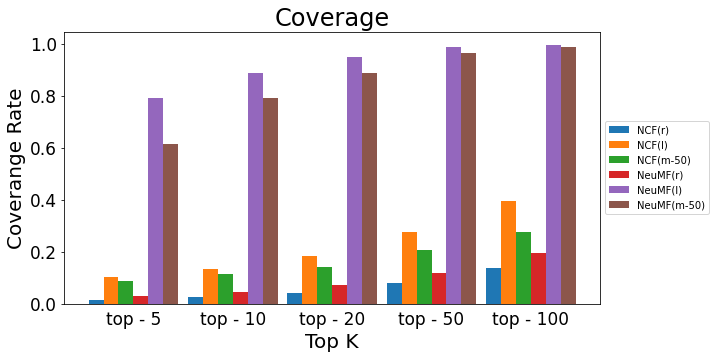

Started Coverage Caclculations


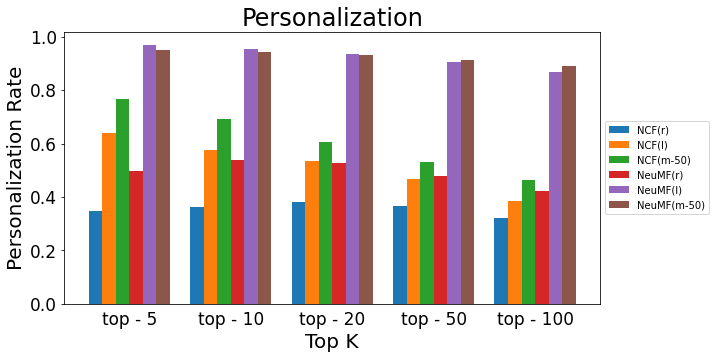

Started Diversity Calculations


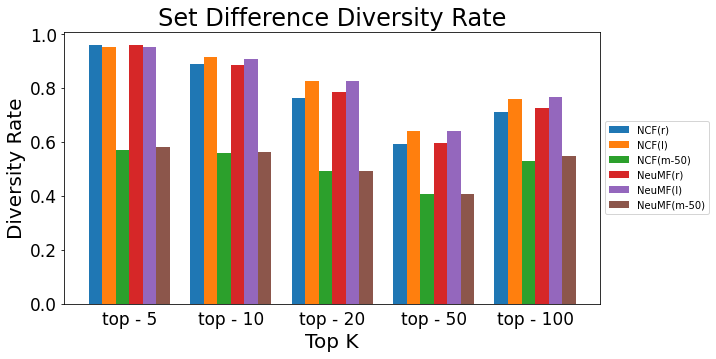

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Hit Rate Calculations


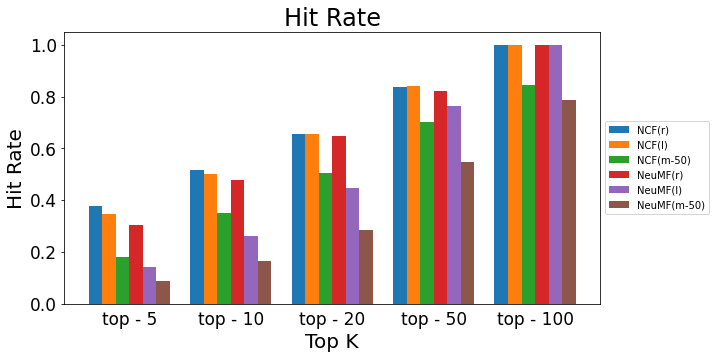

In [ ]:
results = met.run_all()

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Coverage Caclculations


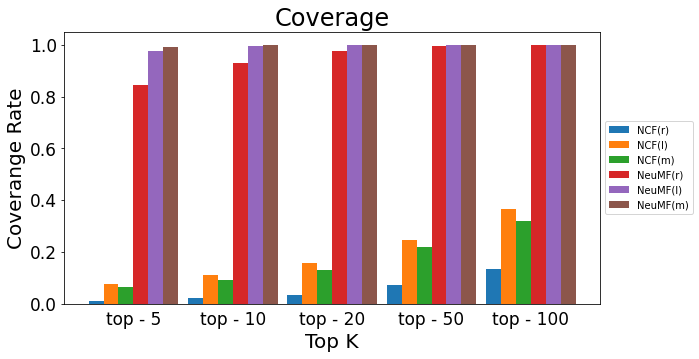

Started Coverage Caclculations


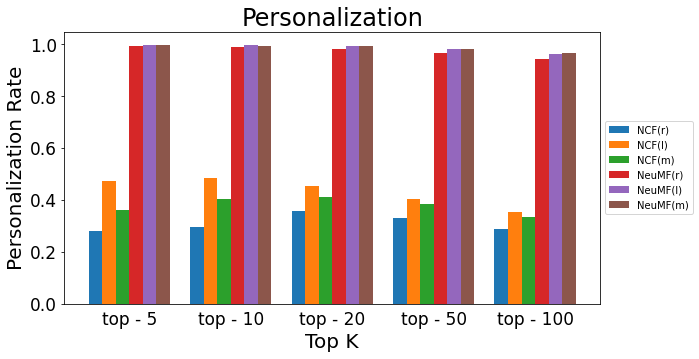

Started Diversity Calculations


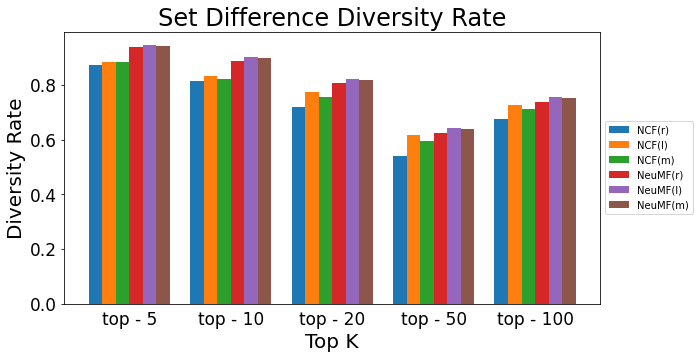

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Hit Rate Calculations


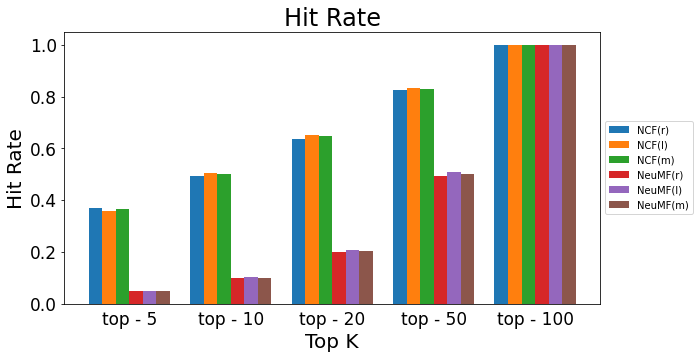

In [ ]:
results = met.run_all()

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Coverage Caclculations


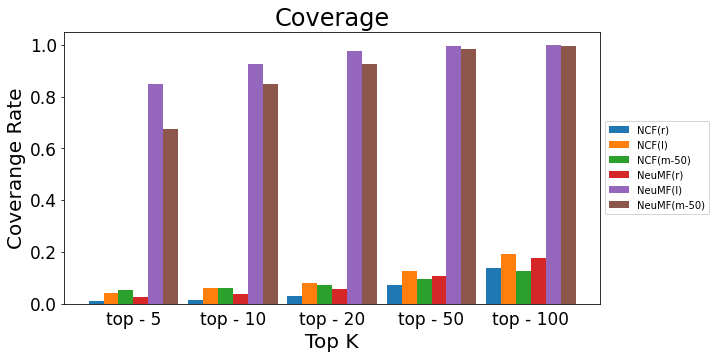

Started Coverage Caclculations


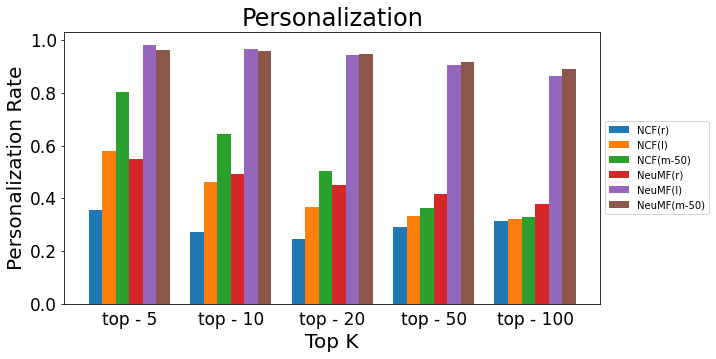

Started Diversity Calculations


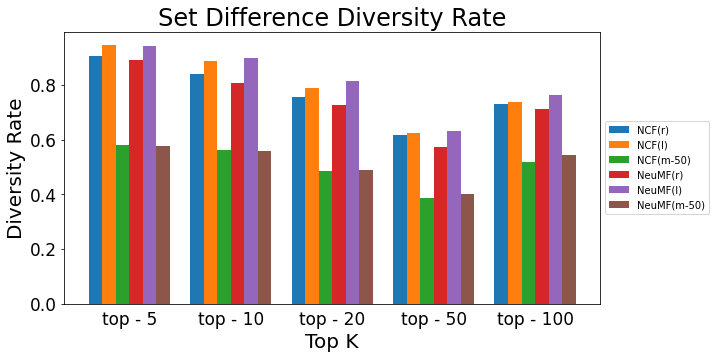

Starting Training


Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Started Hit Rate Calculations


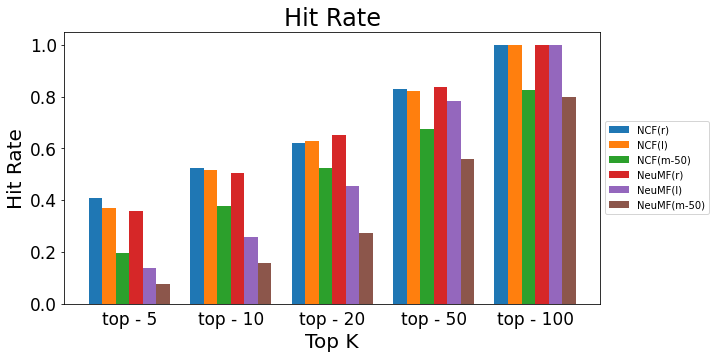

In [ ]:
results = met.run_all()

In [ ]:
nmf_model_ = NeuralMatrixFactorization(NUM_USERS, NUM_MOVIES, 75).cuda()

ncf_model_ = NeuralColabrativeFiltering(NUM_USERS, NUM_MOVIES, 70, 18, 4, 50, movies_tensor).cuda()

neumf_model = NeuMF(nmf_model_, ncf_model_, 80).cuda()

In [ ]:
models = [neumf_model]
names = ["NeuMF"]
train_info = [[1e-1, 1, torch.nn.MSELoss(),1024,[[1e-1,1,torch.nn.MSELoss(),1024],[1e-2,1,torch.nn.CrossEntropyLoss(),1024]]]]

met = metric(models,names,train_info)

Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Mix


Making top k from Mix


Making top k from Mix


Started Coverage Caclculations


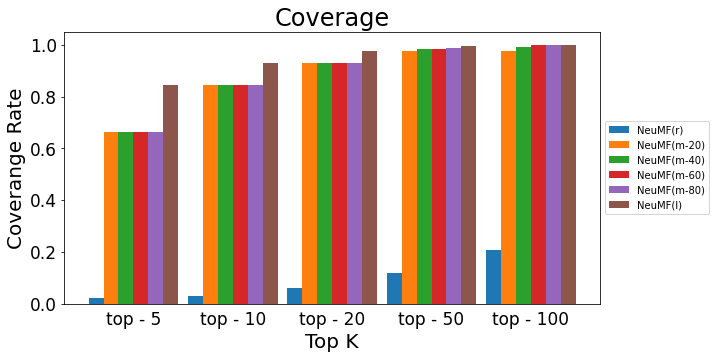

Started Coverage Caclculations


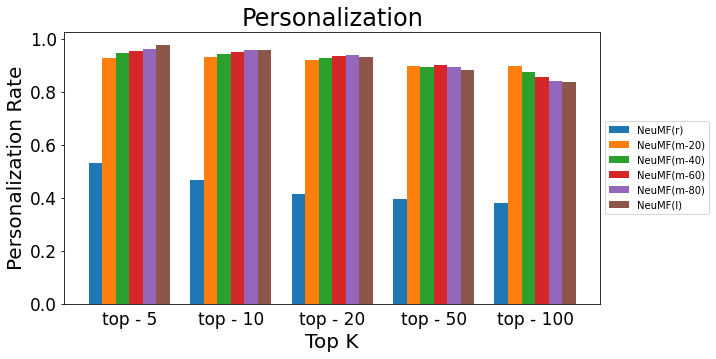

Started Diversity Calculations


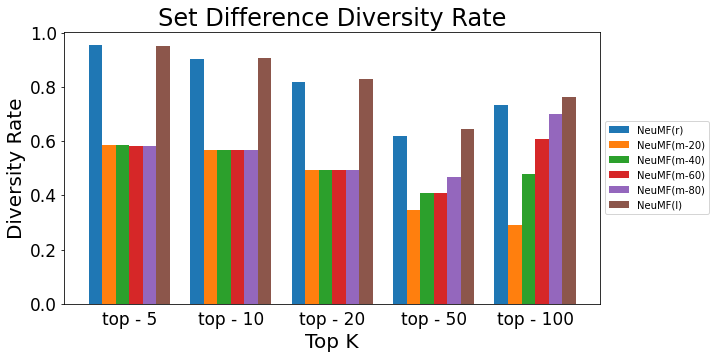

Starting Training


Starting Training


Starting Training


Making top k from Ranking


Making top k from Lexicase


Making top k from Mix


Making top k from Mix


Making top k from Mix


Making top k from Mix


Started Hit Rate Calculations


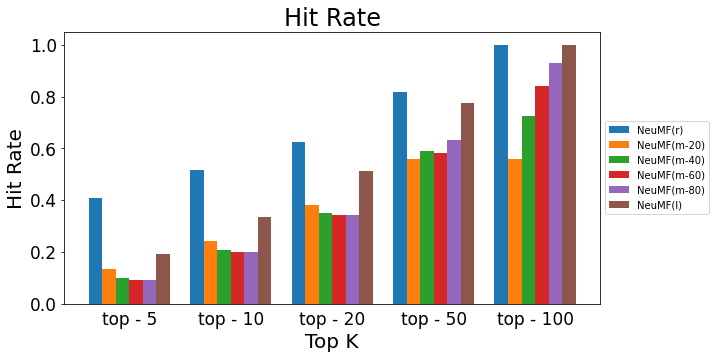

In [ ]:
results = met.run_all()